# Classifier
### Your task
You will implement a multi-layer fully connected neural network using your NeuralNetwork class to predict whether a short DNA sequence is a binding site for the yeast transcription factor Rap1. The training data is incredibly imbalanced, with way fewer positive sequences than negative sequences, so you will implement a sampling scheme to ensure that class imbalance does not affect training. As in step 2, all of the following work should be done in a Jupyter Notebook.

### To-do
* Use the `read_text_file` function from `io.py` to read in the 137 positive Rap1 motif examples.
* Use the `read_fasta_file` function from `io.py` to read in all the negative examples. Note that these sequences are much longer than the positive sequences, so you will need to process them to the same length.
* Balance your classes using your `sample_seq` function and explain why you chose the sampling scheme you did.
* One-hot encode the data using your `one_hot_encode_seqs` function.
* Split the data into training and validation sets.
* Generate an instance of your `NeuralNetwork` class with an appropriate architecture.
* Train your neural network on the training data.
* Plot your training and validation loss by epoch.
* Report the accuracy of your classifier on your validation dataset.
* Explain your choice of loss function and hyperparameters.

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from nn.io import read_text_file, read_fasta_file
from nn.preprocess import sample_seqs, one_hot_encode_seqs
from nn.nn import NeuralNetwork

np.random.seed(0)

## Get data

In [2]:
pos_seqs = read_text_file("data/rap1-lieb-positives.txt")
neg_seqs = read_fasta_file("data/yeast-upstream-1k-negative.fa")

# Generate random sequences for positive samples to insert into
# NOTE: This was something I did after discussing with Dru
len_to_pad_to = len(neg_seqs[0])
seqs_to_insert_into = np.array(["".join(np.random.choice(['A', 'C', 'G', 'T'], len_to_pad_to)) for _ in range(len(pos_seqs))])
print(np.all([len(seq) == len_to_pad_to for seq in seqs_to_insert_into]))
insert_at = np.random.randint(0, len_to_pad_to - 17, len(pos_seqs))

# Insert positive samples into random sequences (pos seqs are length 17)
pos_seqs = np.array([seq[:i] + insert + seq[i+17:] for seq, i, insert in zip(seqs_to_insert_into, insert_at, pos_seqs)])
print(np.all([len(seq) == len_to_pad_to for seq in pos_seqs]))
print(np.all([len(seq) == len_to_pad_to for seq in neg_seqs]))

# pad up to length 1000 for all negative sequences
neg_seqs = np.array([seq + "".join(np.random.choice(['A', 'C', 'G', 'T'], 1000 - len(seq))) for seq in neg_seqs])
print(np.all([len(seq) == len_to_pad_to for seq in neg_seqs]))

print("positive example: ", pos_seqs[0])
print("negative example: ", neg_seqs[0])

all_seqs = np.concatenate((pos_seqs, neg_seqs))
print(all_seqs.shape)
all_labels = [1] * len(pos_seqs) + [0] * len(neg_seqs)
print("length before sample: ", len(all_seqs), len(all_labels))
print("positive samples, negative samples: ", all_labels.count(1), all_labels.count(0))

# Upsample positive sequences
all_seqs, all_labels = sample_seqs(all_seqs, all_labels)
print("length after sample: ", len(all_seqs), len(all_labels))
print("positive samples, negative samples: ", all_labels.count(1), all_labels.count(0))

True
True
False
True
positive example:  ATCATTTTCTCGATGAAAGCGTTGACCCCACATATCGTTAGTACTCTTGTACCCTATGATTGTGTAGAAACCGAACTACGGTACCTCCTGTTGGTAGTCACGATAGATTATAAAAGTATGTTCCCACCCTATCGACGAGACTGGCATCCTAGGTGTTTGCGGTGTTGGTACGTGCGCAGGTATGTAAGAGTGGTAAACGACGTGGTCAAATTAGGAATACGAATCTAGCCCTAAACCGCAACGCCTCAAATTCGCTCTAATCGAGTTGTCCCTGAACATGTTGAGTGGCCTTATAAGGTCCATAGTTCTCTGACCTTTCCCTTGGGATTCGTCTTCCCAGGACCATAATGCGCGACATCCGTGCACCTCCGATGGCCCGCCACGCCAACCGTTCTTTGGCGTGATTCCCGCCCGATCATCCGAGTAGAGAATTTAATCTGTATATTCGCAATATAACAGGGAAGAGTGTTACCCAATTCTATACGGAGCTTTCGCGTGCGTTAAGCTCGGCAGTAGATGCGCACCGGTACATAAGATCATGCTACGAAAGCTAAAACTGGCACCCTTCCTCTTGGTCCCGATAACACATGGCAAAAATGCAGTTTTAGCATTTTAGCGGCTTAAGCCATAGATCGTGCAACAAGAACTCCCCTCGAGATTCTATGATTTACTTGCTTCCAATGAATGCGTGTTATGGATGCATCGCCACCTCTGACCTTACGACGCGCTGTCGTGGGATGGTGGACATGAAGTCTGGCCGTCGCTGTACCGGAGCTGATCGAGCGCAACAGATCGAGTAACACAGTTAGCTTAGAGATGGAAGCTCCCAGCCTTCTCTGAGCCCCGACGTCTCCGAGGTGGGATCCTTGTGGCTCTCGGCGACCTGATCAAGCTACGCGCTCTGAATCCCAGGGAGTTACGGTACGAAGCGATTAACACACGTCTGCGCTGAGCTAAGGA

In [3]:
# One hot encode
all_seqs = one_hot_encode_seqs(all_seqs)
print("one hot encoded: ", all_seqs[0], "length: ", len(all_seqs[0]))

one hot encoded:  [0. 1. 0. ... 0. 0. 0.] length:  4000


In [4]:
# Random split into training and validation (80/20)
np.random.seed(0)
indices = np.random.permutation(len(all_seqs))
train_seqs = all_seqs[indices[: -len(indices) // 5]]
train_labels = np.array(all_labels)[indices[: -len(indices) // 5]]
val_seqs = all_seqs[indices[-len(indices) // 5 :]]
val_labels = np.array(all_labels)[indices[-len(indices) // 5 :]]
print("train length: ", len(train_seqs), len(train_labels))
print("val length: ", len(val_seqs), len(val_labels))

train length:  5060 5060
val length:  1266 1266


## Build model

In [5]:
input_length = len(train_seqs[0])
print(input_length)

4000


In [18]:
nn = NeuralNetwork(
    nn_arch=[
        {"input_dim": input_length, "output_dim": 500, "activation": "relu"},
        {"input_dim": 500, "output_dim": 250, "activation": "relu"},
        {"input_dim": 250, "output_dim": 50, "activation": "relu"},
        {"input_dim": 50, "output_dim": 1, "activation": "sigmoid"}
    ],
    lr=0.1,
    seed=0,
    batch_size=100,
    epochs=200,
    loss_function="bce",
)

In [19]:
print(train_seqs.shape)
print(train_labels.shape)  # labels should get reshaped in nn.backprop

(5060, 4000)
(5060,)


In [20]:
per_epoch_loss_train, per_epoch_loss_val = nn.fit(
    train_seqs, train_labels, val_seqs, val_labels
)

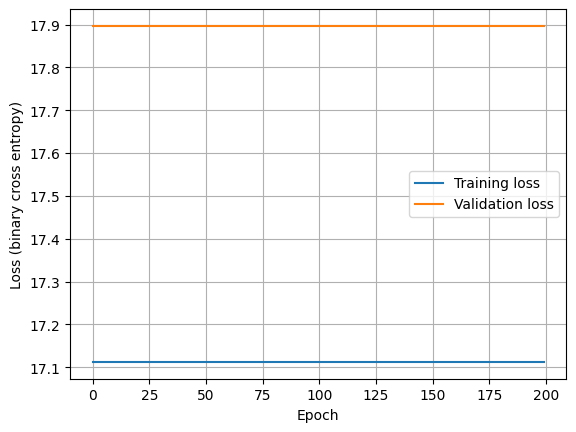

In [21]:
plt.plot(per_epoch_loss_train, label="Training loss")
plt.plot(per_epoch_loss_val, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (binary cross entropy)")
plt.legend()
plt.grid()
plt.show()

In [22]:
val_predictions = nn.predict(val_seqs)
val_predictions = np.round(val_predictions)
val_accuracy = np.mean(val_predictions == val_labels)
print("Validation accuracy: ", val_accuracy)

Validation accuracy:  0.48183254344391785


In [23]:
# Confusion matrix
confusion_matrix = np.zeros((2, 2))
for i in range(len(val_predictions)):
    confusion_matrix[int(val_labels[i])][int(val_predictions[i])] += 1

# plt.imshow(confusion_matrix, cmap="Blues")
# plt.xlabel("Predicted")
# plt.ylabel("True")
print(confusion_matrix)

[[610.   0.]
 [656.   0.]]


/var/folders/dk/qssfz_y127l475pyh6f7y0yw0000gp/T/ipykernel_75785/3428146520.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confusion_matrix[int(val_labels[i])][int(val_predictions[i])] += 1


## Explanation of hyperparameters
The accuracy on this terrible - I tried to improve it for a long time by using different optimization methods, but overall found that I could not seem to get much better than 50% (guessing, essentially). I chose my architecture in order to try and overfit to the dataset during training, and I would then tune it to achieve better generalization on the validation set. I originally tried tuning hyperparameters to fit just one sample, which can help with ensuring that the network is working properly. This showed that the network was constantly predicting some value ~0.5. I tried a range of learning rates, from 0.1 to 0.0000001, and none seem to provide reliable decreases in training loss. I set the batch size to 1 to ensure that the batch averaging was not affecting the learning. I looked directly at the gradients and the partials w.r.t. weights and biases, and noticed that the partials seem very small. The gradient then barely changes, because the weights barely change. Even with a relatively large learning rate (0.1) the partials are very small (~0.01). My binary cross entropy loss and backpropogation functions do the correct calculation, so I am not sure what exactly is wrong. I would like to look into it more, but given my workload in other areas this week, I will not have time before this is due. Perhaps this dataset is just very challenging to learn!

The next steps I would do to try and fix this would be to train a classifier on a fake, dummy dataset that I create, just to verify that all my neural network functions are doing what is expected - they pass all the tests and work great on the autoencoder, so it must be specific to the BCE loss or sigmoid. After that, I would try to just learn the small number of original positive samples to see if I could get the network to memorize those, and then move on to training on the whole dataset again.